<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 13: Classifiers
### Notebook 4: Naive Bayes

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_moons
from sklearn.naive_bayes import GaussianNB
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()

In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [3]:
def show_Xy(X, y, filename):
    plt.scatter(X[:,0], X[:,1], c=y, s=80, cmap=dot_cmap)
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

In [4]:
def gaussian_height(x, y, mu, std):
    hx = np.exp(-0.5 * (x - mu[0]) ** 2 / std[0] ** 2)
    hy = np.exp(-0.5 * (y - mu[1]) ** 2 / std[1] ** 2)
    h = hx*hy
    return h

In [5]:
def get_Z_heights(X, y):
    xlim = (np.min(X[:,0]), np.max(X[:,0]))
    ylim = (np.min(X[:,1]), np.max(X[:,1]))
    resolution = 100

    xg = np.linspace(xlim[0], xlim[1], resolution)
    yg = np.linspace(ylim[0], ylim[1], resolution)
    xx, yy = np.meshgrid(xg, yg)
    xy_grid = np.vstack([xx.ravel(), yy.ravel()]).T
    
    X0 = X[y==0]
    X1 = X[y==1]

    mean_0 = (np.mean(X0[:,0]), np.mean(X0[:,1]))
    var_0 = (np.std(X0[:,0]), np.std(X0[:,1]))

    mean_1 = (np.mean(X1[:,0]), np.mean(X1[:,1]))
    var_1 = (np.std(X1[:,0]), np.std(X1[:,1]))
    
    Z0 = np.array([gaussian_height(x,y,mean_0,var_0) for x,y in zip(np.ravel(xx), np.ravel(yy))])
    Z0 = Z0.reshape(xx.shape)
    Z1 = np.array([gaussian_height(x,y,mean_1,var_1) for x,y in zip(np.ravel(xx), np.ravel(yy))])
    Z1 = Z1.reshape(xx.shape)
    return (Z0, Z1, xx, yy)

In [6]:
def show_3D_gaussians(X, y, filename):
    X0 = X[y==0]
    X1 = X[y==1]

    Z0, Z1, xx, yy = get_Z_heights(X, y)

    fig = plt.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1, projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(xx, yy, Z1, rstride=1, cstride=1, cmap=img_cmap, alpha=1, linewidth=0, antialiased=False)
    ax.view_init(30, 80)
    fig.add_subplot(1, 2, 2, projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(xx, yy, Z0, rstride=1, cstride=1, cmap=img_cmap, alpha=1, linewidth=0, antialiased=False)
    ax.view_init(30, 80)
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [7]:
def show_Gauss_and_dots(X, y, filename):
    X0 = X[y==0]
    X1 = X[y==1]
    Z0, Z1, xx, yy = get_Z_heights(X, y)
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(Z0, cmap=img_cmap, aspect='auto',
               extent=(np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])), 
               origin='lower', alpha=0.5, zorder=5)
    #plt.scatter(X0[:,0], X0[:,1], facecolor=dot_clr_0, lw=1, s=50, alpha=0.2, cmap=dot_cmap, zorder=10)
    plt.scatter(X0[:,0], X0[:,1], facecolor='none', edgecolor=dot_clr_0, lw=0.5, s=50, cmap=dot_cmap, zorder=10)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(1, 2, 2)
    plt.imshow(Z1, cmap=img_cmap, aspect='auto',
               extent=(np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])), 
               origin='lower', alpha=0.5, zorder=5)
    #plt.scatter(X1[:,0], X1[:,1], facecolor=dot_clr_1, lw=1, s=50, alpha=0.2, cmap=dot_cmap, zorder=10)
    plt.scatter(X1[:,0], X1[:,1], facecolor='none', edgecolor=dot_clr_1, lw=0.5, s=50, cmap=dot_cmap, zorder=10)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [8]:
def show_predictions(X, y, filename):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictions = gnb.predict(X_test)

    X0 = X[y==0]
    X1 = X[y==1]
    Z0, Z1, xx, yy = get_Z_heights(X, y)
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(Z0, cmap=img_cmap, aspect='auto',
               extent=(np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])), 
               origin='lower', alpha=0.5, zorder=5)
    
    mask = predictions == 0
    correct = predictions[mask] == y_test[mask]
    clrs = [dot_clr_0 if c else dot_clr_1 for c in correct]
    #plt.scatter(X_test[mask,0], X_test[mask,1], facecolor=clrs, lw=1, s=50, cmap=dot_cmap, zorder=10)
    plt.scatter(X_test[mask,0], X_test[mask,1], facecolor='none', edgecolor=dot_clr_0, lw=1, s=50, cmap=dot_cmap, zorder=10)
    plt.xticks([],[])
    plt.yticks([],[])
    
    
    plt.subplot(1, 2, 2)
    plt.imshow(Z1, cmap=img_cmap, aspect='auto',
               extent=(np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])), 
               origin='lower', alpha=0.5, zorder=5)
    mask = predictions == 1
    correct = predictions[mask] == y_test[mask]
    clrs = [dot_clr_1 if c else dot_clr_0 for c in correct]
    #plt.scatter(X_test[mask,0], X_test[mask,1], facecolor=clrs, lw=1, s=50, cmap=dot_cmap, zorder=10)
    plt.scatter(X_test[mask,0], X_test[mask,1], facecolor='none', edgecolor=dot_clr_1, lw=1, s=50, cmap=dot_cmap, zorder=10)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

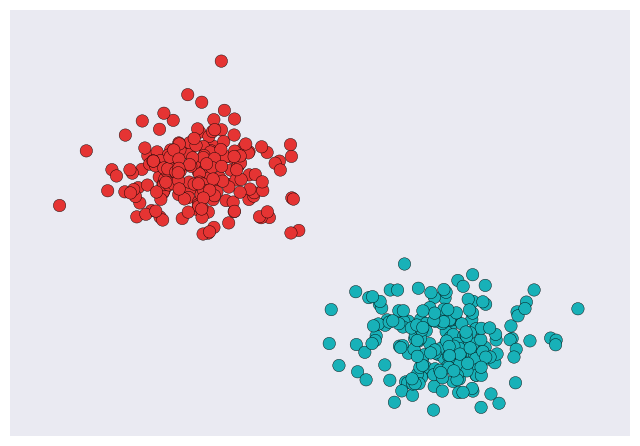

In [9]:
dot_clr_0 = '#E53433' # red 
dot_clr_1 = '#18B1B8'  # blue
dot_cmap = LinearSegmentedColormap.from_list('dot_map', [dot_clr_0, dot_clr_1], N=100)
img_cmap = 'cool'
X_blobs, y_blobs = make_blobs(n_samples=400, n_features=2, centers=2, random_state=42, cluster_std=1.25)
show_Xy(X_blobs, y_blobs, 'NB-start-blobs')

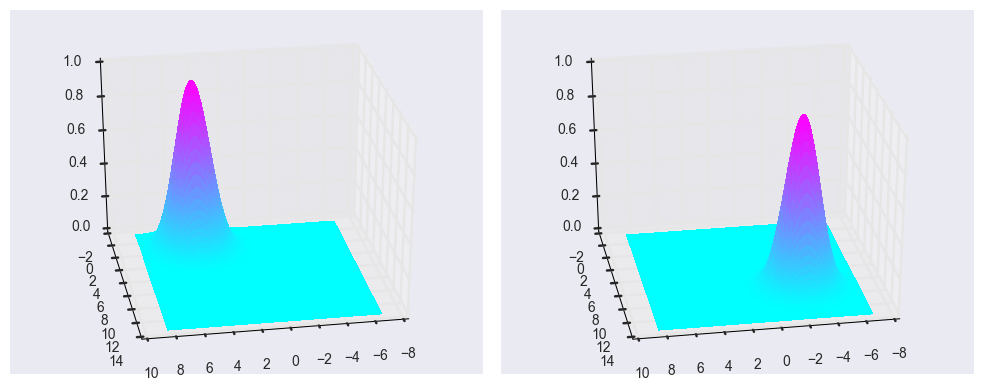

In [10]:
nb_blobs = GaussianNB()
nb_blobs.fit(X_blobs, y_blobs)
show_3D_gaussians(X_blobs, y_blobs, 'NB-gaussians-3D-blobs')

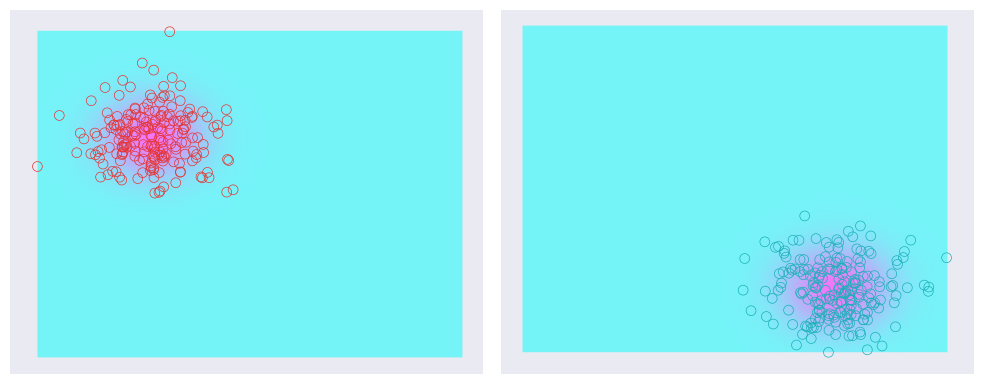

In [11]:
show_Gauss_and_dots(X_blobs, y_blobs, 'NB-dots-blobs')

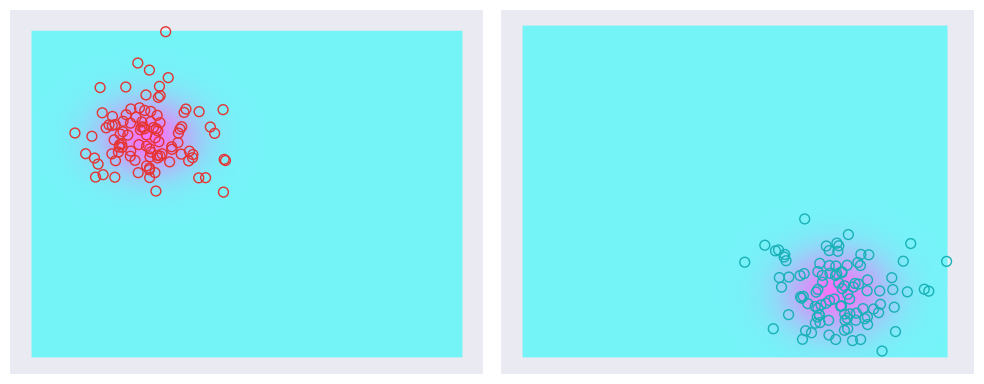

In [12]:
show_predictions(X_blobs, y_blobs, 'NB-Blob-predictions')

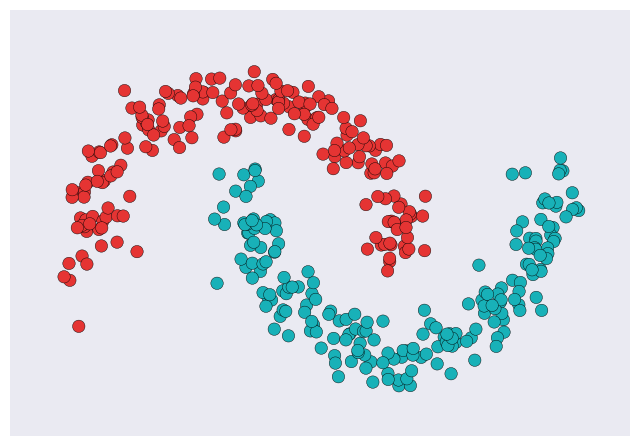

In [13]:
X_moons, y_moons = make_moons(n_samples=400, shuffle=True, noise=0.1, random_state=42)
show_Xy(X_moons, y_moons, 'NB-start-moons')

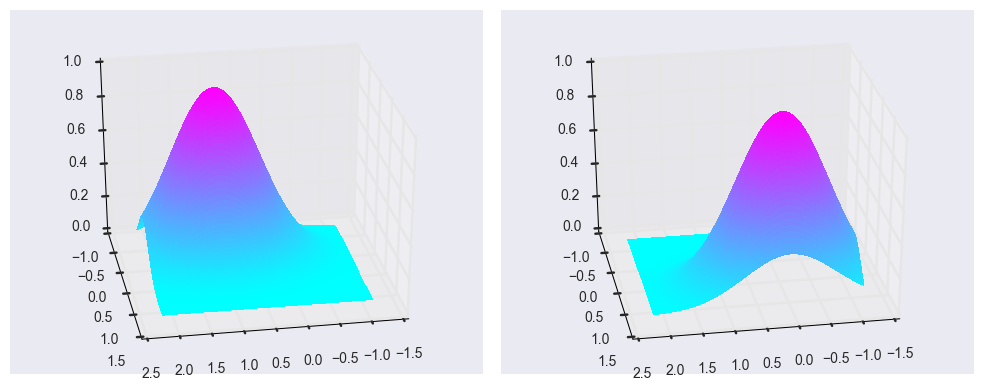

In [14]:
nb_gaussian = GaussianNB()
nb_gaussian.fit(X_moons, y_moons)
show_3D_gaussians(X_moons, y_moons, 'NB-gaussians-3D-moons')

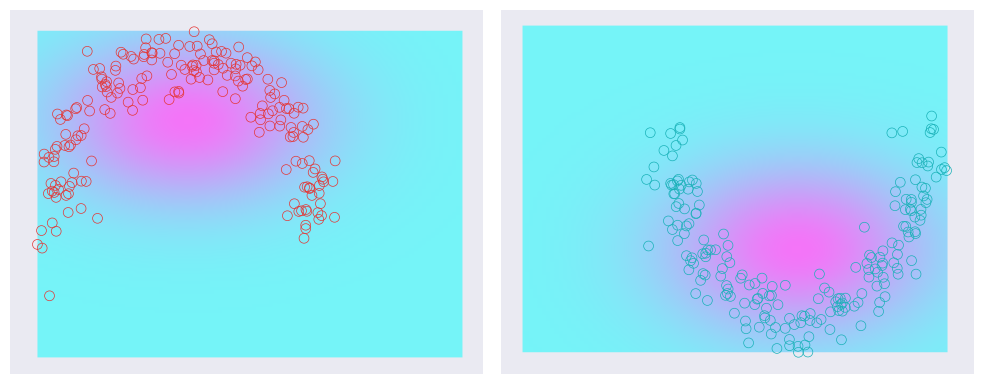

In [15]:
show_Gauss_and_dots(X_moons, y_moons, 'NB-dots-moons')

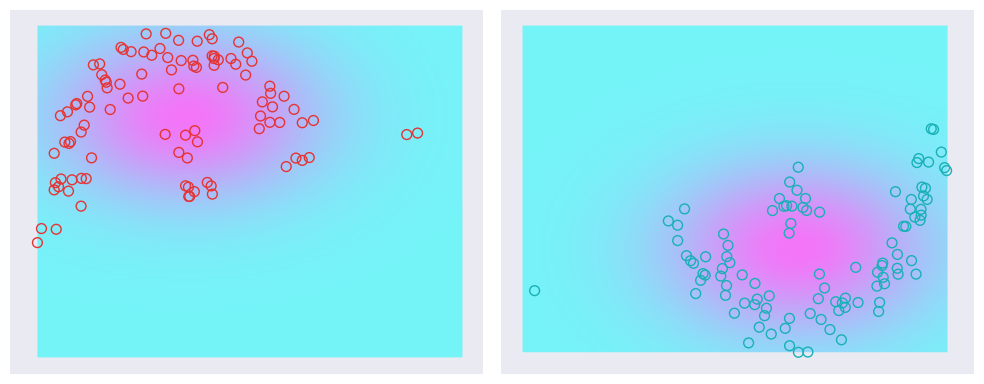

In [16]:
show_predictions(X_moons, y_moons, 'NB-Moon-predictions')